In [179]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________
import ERROR
import CONFIG
import DBPARSE
from PXPY import *
from ASYMMETRY import *
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
import CORRECTIONS
import CALCULATE
import GETFF
from joblib import Parallel, delayed
import importlib
#importlib.reload(ASYMMETRY)

In [ ]:
###############################################################################
###############################################################################

#NEEDS INELASTIC ASYMMETRY, NITROGEN CONTAMINATION, GRINCH CUTS, AND ERROR PROP

###############################################################################
###############################################################################

In [2]:
Pass="1"
config="3"

In [3]:
W2min=CONFIG.Function_JSON("W2min",f"../config/Pass{Pass}/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/Pass{Pass}/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/Pass{Pass}/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/Pass{Pass}/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/Pass{Pass}/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/Pass{Pass}/cuts{config}.cfg")
Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")

#  "dxmin"	: -0.481,
#  "dxmax"	: 0.498, old gen2


print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Q2: {Q2}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min: -0.5
W2max: 1.7
dxmin: -0.4
dxmax: 0.4
dymin: -0.5
dymax: 0.5
dybgmin: -1.3
dybgmax: 1.2
Q2: 6.83
Coin Min: 88 Coin Max: 100


In [4]:
#in GeV^2
m=.939565
muN=-1.9103
if config=="2":
    Q2=3
    tau=Q2/(4*m**2)
    theta=29.5*pi/180
if config=="3":
    Q2=6.83
    #Q2=6.62 #seans number
    tau=Q2/(4*m**2)
    theta=36.5*pi/180
if config=="4":
    Q2=9.82
    tau=Q2/(4*m**2)
    theta=35*pi/180

# Target Spin Direction

In [5]:
if config=="2":
    spintheta=59.34
    spinphi=1.84
if config=="3":
    spintheta=70.94
    spinphi=.51
if config=="4":
    spintheta=74.07
    spinphi=.55





In [6]:
%%time
fileNum=1
#generic=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/He3/generic{fileNum}.npz")
genericSim=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpySim/GEN{config}/simulation0.npz")
genericSimIN=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpySim/GEN{config}/insimulation0.npz")

print(genericSim.files)
print(genericSimIN.files)


['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'ephi', 'trP', 'fnucl', 'weight']
['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'trP', 'fnucl', 'weight', 'mc_sig']
CPU times: user 17.8 ms, sys: 7.04 ms, total: 24.9 ms
Wall time: 2.24 s


In [7]:
dataTarget = pd.read_csv('../DB/ProcessedHe3Pol.csv')
dataBeam = pd.read_csv('../DB/ProcessedBeamPol.csv')
target_run_num = dataTarget['Run Number'].to_numpy()
target_pol = dataTarget['Polarization'].to_numpy()
target_polE=dataTarget['Error'].to_numpy()
beam_run_num = dataBeam['Run Number'].to_numpy()
beam_pol = dataBeam['Polarization'].to_numpy()
beam_polE=dataBeam['Error'].to_numpy()

In [8]:
%%time
genericMaster = {}
base_dir = f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/He3"
i = 0
while os.path.exists(f"{base_dir}/generic{i}.npz"):
    file_path = f"{base_dir}/generic{i}.npz"
    data = np.load(file_path)

    for key in data.files:
        if key not in genericMaster:
            genericMaster[key] = data[key]
        else:
            genericMaster[key] = np.concatenate((genericMaster[key], data[key]))

    data.close()
    i += 1

print(f"Loaded {i} files into genericMaster.")


Loaded 13 files into genericMaster.
CPU times: user 7.99 s, sys: 8.82 s, total: 16.8 s
Wall time: 52.6 s


In [9]:
generic=genericMaster

# Cuts

### Making the correct helicity

In [10]:
IHWP_IN=np.where(generic["IHWP"]==1)
helicity=generic["helicity"]
helicity[IHWP_IN]*=-1

### Cuts for data, bgsim, np sim 

In [516]:
wcut=(generic["W2"] < W2max)&(generic["W2"]>W2min) 
dycut=(abs(generic["dy"]) < 0.5) 
dxcut=(generic["dx"] < dxmax)&(generic["dx"]>dxmin) 
coincut=(coinmin < generic["coin_time"])&(generic["coin_time"] < coinmax)
anticoincut=(coinmin-8 > generic["coin_time"])|(generic["coin_time"] > coinmax+5)

fullcut=wcut & dycut & dxcut & coincut
hpluscut=helicity==1
hminuscut=helicity==-1

bgcut=(genericSimIN["W2"] < W2max)&(genericSimIN["W2"]>W2min)&(abs(genericSimIN["dy"]) < 0.5) 

Simwcut=(genericSim["W2"] < W2max)&(genericSim["W2"]>W2min) 
Simdycut=(abs(genericSim["dy"]) < 0.5) 
Simdxcut=(genericSim["dx"] < dxmax)&(genericSim["dx"]>dxmin) 
Simfullcut=Simwcut & Simdycut & Simdxcut

InSimdxcut=(genericSimIN["dx"] < dxmax)&(genericSimIN["dx"]>dxmin)
InSimdycut=(genericSimIN["dy"] < dymax)&(genericSimIN["dy"]>dymin)

# Data Histograms

12

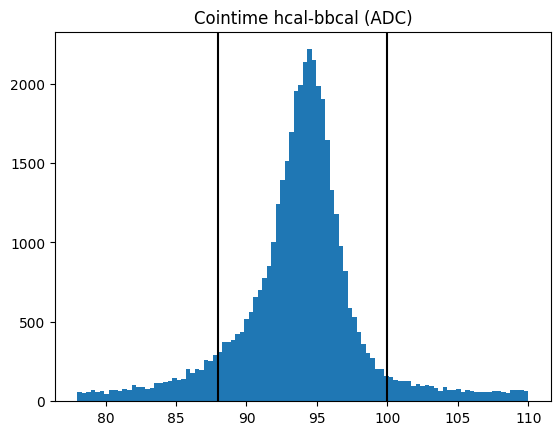

In [517]:
d=plt.hist(generic["coin_time"][wcut&dycut&dxcut],bins=100,range=(coinmin-10,coinmax+10))
plt.title("Cointime hcal-bbcal (ADC)")
plt.axvline(coinmin,color='black')
plt.axvline(coinmax,color='black')
coinmax-coinmin

In [518]:
coinmax

100

Text(0.5, 1.0, 'W$^2$ using 4-momentum of virtual photon (model 2)')

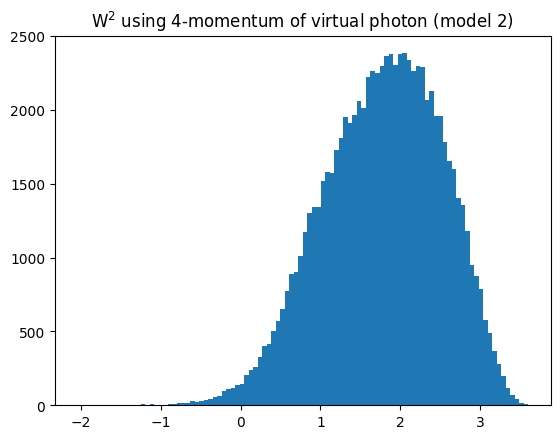

In [519]:
d=plt.hist(generic["W2"][dycut&dxcut&coincut],bins=100)
plt.title(r"W$^2$ using 4-momentum of virtual photon (model 2)")

Text(0.5, 1.0, '$\\Delta Y$')

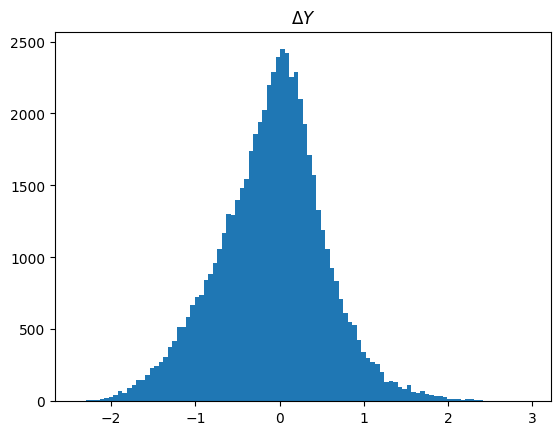

In [520]:
d=plt.hist(generic["dy"][coincut&wcut&dxcut],bins=100)
plt.title(r"$\Delta Y$")

Text(0.5, 1.0, '$\\Delta X$')

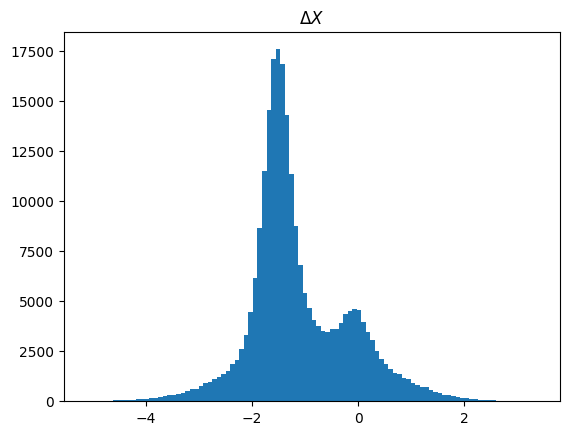

In [521]:

d=plt.hist(generic["dx"][dycut&coincut&wcut],bins=100)
plt.title(r"$\Delta X$")

# Simulation Histograms

### Quasi Elastic

In [522]:
protoncut=genericSim["fnucl"]==1
neutroncut=genericSim["fnucl"]==0
weight=genericSim["weight"]

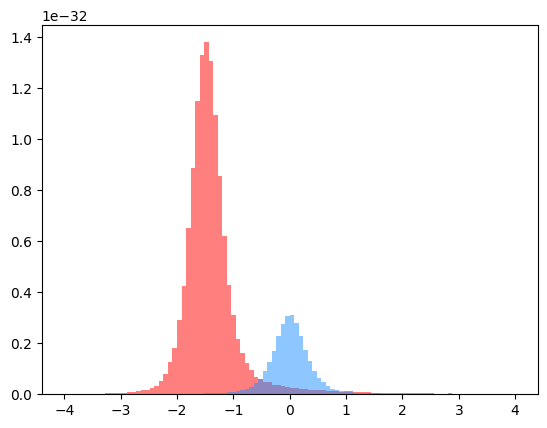

In [523]:
hdx_sim_p=plt.hist(genericSim["dx"][protoncut],range=(-4,4),bins=100,color='red',weights=weight[protoncut],alpha=.5)
hdx_sim_n=plt.hist(genericSim["dx"][neutroncut],range=(-4,4),bins=100,color='dodgerblue',weights=weight[neutroncut],alpha=.5)


### Inelastic

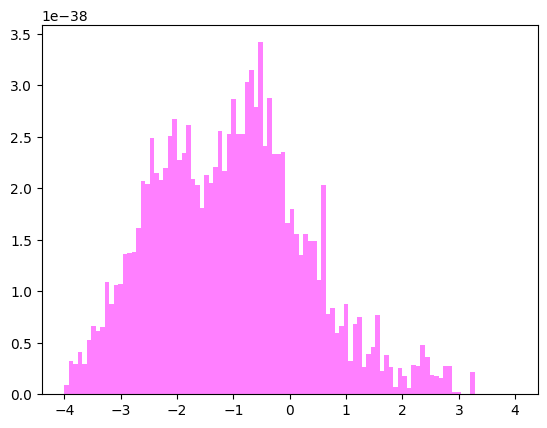

In [524]:
inweight=genericSimIN["weight"]
hdx_sim_bg=plt.hist(genericSimIN["dx"][bgcut],range=(-4,4),bins=100,weights=inweight[bgcut],color='magenta',alpha=.5)


# Fit dX

In [525]:
plt.figure(figsize=(10,6),dpi=200)

counts_p, bin_edges = np.histogram(genericSim["dx"][protoncut], bins=100, range=(-4, 3), weights=weight[protoncut])
counts_n, _         = np.histogram(genericSim["dx"][neutroncut], bins=bin_edges, weights=weight[neutroncut])
counts_bg,_         = np.histogram(genericSimIN["dx"][bgcut],bins=bin_edges,weights=genericSimIN["weight"][bgcut])
counts_acc,_        =np.histogram(generic["dx"][wcut&dycut&anticoincut],bins=bin_edges)
counts_data, _      = np.histogram(generic["dx"][dycut & coincut & wcut], bins=bin_edges)

counts_p = counts_p.astype(float)
counts_n = counts_n.astype(float)
counts_bg = counts_bg.astype(float)
counts_acc = counts_acc.astype(float)
counts_data = counts_data.astype(float)
bin_centers         = (bin_edges[:-1] + bin_edges[1:]) / 2
shape=("from data")
fit_obj = DistributionFits(bg_shape_option=shape)
fit_obj.hdx_data = [bin_centers, counts_data]
fit_obj.hdx_sim_p = [bin_centers, counts_p]
fit_obj.hdx_sim_n = [bin_centers, counts_n]
fit_obj.hdx_bg_data = [bin_centers, counts_bg] 
fit_obj.hdx_acc_data = [bin_centers, counts_acc] 


if shape=="from data+acc":
    bg_fit, total_fit, sim_p_scaled, sim_n_scaled,pop0,pop1,pop2,pop3,scale,acc_fit= fit_obj.He3_fit_dists(True)
else:
    bg_fit, total_fit, sim_p_scaled, sim_n_scaled,pop0,pop1,pop2,scale= fit_obj.He3_fit_dists(True)



<Figure size 2000x1200 with 0 Axes>

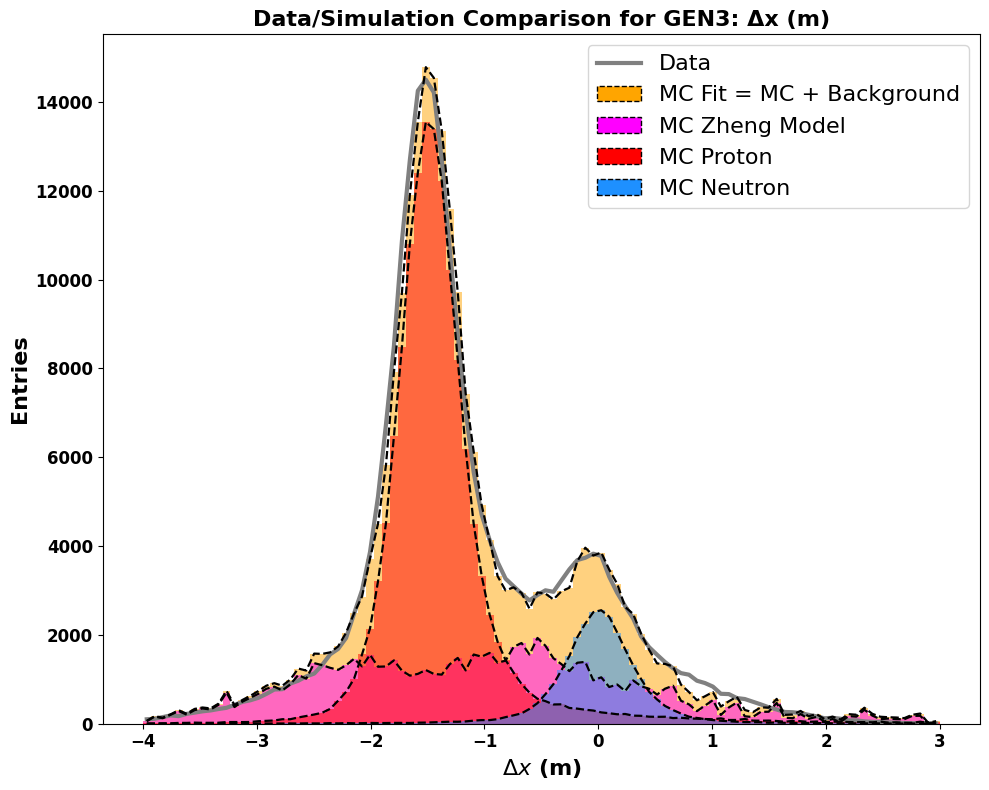

Total entries in fit: 243983.31360878627


In [526]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Style config
fig, ax = plt.subplots(figsize=(10, 8))
lw = 1.6
l = 3
fs = 16
fw = 'bold'
a = 1  # transparency for bars
bin_width = bin_centers[1] - bin_centers[0]

# Optional override
if config == "2":
    lw = 1
    l = 3
    typ = "4th Order Poly"
else:
    typ = "Background Data"

# --------- Data Line ---------
#ax.bar(bin_centers, counts_data, width=bin_width, align='center', alpha=0.5, color='grey', label="Data")
ax.plot(bin_centers, counts_data, '-', color='grey', linewidth=l, label='Data')

# --------- Total Fit ---------
ax.bar(bin_centers, total_fit, width=bin_width, align='center', alpha=0.5, color='orange', label="MC Fit = MC + Background")
ax.plot(bin_centers, total_fit, '--', color='black', linewidth=lw)

# --------- Inelastic ---------
ax.bar(bin_centers, bg_fit, width=bin_width, align='center', alpha=0.5, color='magenta', label="MC Inelastic")
ax.plot(bin_centers, bg_fit, '--', color='black', linewidth=lw)

# --------- Accidental ---------
#ax.bar(bin_centers, acc_fit, width=bin_width, align='center', alpha=0.5, color='magenta', label="MC Inelastic")
#ax.plot(bin_centers, acc_fit, '--', color='black', linewidth=lw)

# --------- Sim Proton ---------
ax.bar(bin_centers, sim_p_scaled, width=bin_width, align='center', alpha=0.5, color='red', label="MC Proton")
ax.plot(bin_centers, sim_p_scaled, '--', color='black', linewidth=lw)

# --------- Sim Neutron ---------
ax.bar(bin_centers, sim_n_scaled, width=bin_width, align='center', alpha=0.5, color='dodgerblue', label="MC Neutron")
ax.plot(bin_centers, sim_n_scaled, '--', color='black', linewidth=lw)

# --------- Custom Legend ---------
legend_elements = [
    Line2D([0], [0], color='grey', linewidth=3, linestyle='-', label='Data'),
    Patch(facecolor='orange', edgecolor='black', linestyle='--', label='MC Fit = MC + Background', alpha=a),
    Patch(facecolor='magenta', edgecolor='black', linestyle='--', label='MC Zheng Model', alpha=a),
    Patch(facecolor='red', edgecolor='black', linestyle='--', label='MC Proton', alpha=a),
    Patch(facecolor='dodgerblue', edgecolor='black', linestyle='--', label='MC Neutron', alpha=a)
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=fs)

# --------- Labels, ticks, etc. ---------
ax.set_title(f'Data/Simulation Comparison for GEN{config}: Δx (m)', fontsize=fs, fontweight=fw)
ax.set_xlabel(r'$\Delta x$ (m)', fontsize=fs, fontweight=fw)
ax.set_ylabel('Entries', fontsize=fs, fontweight=fw)
ax.tick_params(axis='both', labelsize=fs-4)
plt.xticks(fontsize=fs-4, fontweight=fw)
plt.yticks(fontsize=fs-4, fontweight=fw)
plt.tight_layout()

# --------- Save and show ---------
#plt.savefig(f'../plots/DataSimPass{pas}GEN{config}.png')
plt.show()

# Optional: Check total counts
print("Total entries in fit:", np.sum(total_fit))


In [527]:
def compute_reduced_chi2(y_obs, y_fit, n_params):
    valid = y_obs > 0  # Ignore bins with no data
    residuals = y_obs[valid] - y_fit[valid]
    errors = np.sqrt(y_obs[valid] + (0.03 * y_obs[valid])**2)  # 2% systematic uncertainty

    chi2 = np.sum((residuals / errors)**2)

    dof = np.sum(valid) - n_params
    reduced_chi2 = chi2 / dof if dof > 0 else np.nan

    return reduced_chi2, chi2, dof
n_fit_params = 3  # Norm_overall, R_pn, Bg_norm — from 'from data' bg, so no bg shape params

reduced_chi2, chi2, dof = compute_reduced_chi2(counts_data, total_fit, n_fit_params)

print(f"χ² = {chi2:.2f}")
print(f"ndf = {dof}")
print(f"Reduced χ² = {reduced_chi2:.2f}")


χ² = 14620.14
ndf = 97
Reduced χ² = 150.72


In [528]:
def compute_log_likelihood(y_obs, y_fit):
    valid = y_obs > 0
    ratio = y_obs[valid] / y_fit[valid]
    ll = 2 * np.sum(y_obs[valid] * np.log(ratio))
    return ll


compute_log_likelihood(counts_data,total_fit)

4757.665870178355

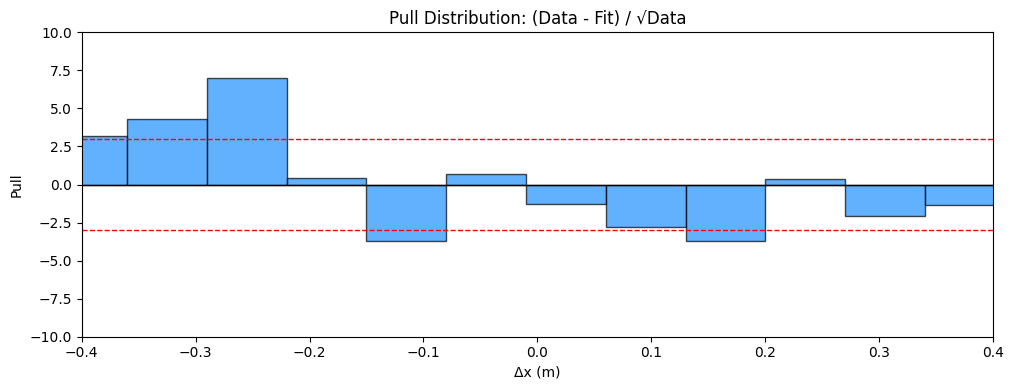

In [529]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pulls(x, data_counts, model_counts):
    # Only compute pulls where data > 0 to avoid divide-by-zero
    valid = data_counts > 0
    pulls = np.zeros_like(data_counts)
    pulls[valid] = (data_counts[valid] - model_counts[valid]) / np.sqrt(data_counts[valid])
    
    plt.figure(figsize=(10, 4))
    plt.axhline(0, color='black', lw=1)
    plt.axhline(3, color='red', ls='--', lw=1)
    plt.axhline(-3, color='red', ls='--', lw=1)
    plt.bar(x, pulls, width=(x[1] - x[0]), alpha=0.7, color='dodgerblue', edgecolor='black')
    plt.xlabel("Δx (m)")
    plt.ylabel("Pull")
    plt.title("Pull Distribution: (Data - Fit) / √Data")
    plt.tight_layout()
    plt.ylim(-10,10)
    plt.xlim(dxmin,dxmax)

    plt.show()
plot_pulls(bin_centers, counts_data, total_fit)

# Fit Fractions

In [530]:
# Find indices of bins within dxmin and dxmax
mask = (bin_centers >= dxmin) & (bin_centers <= dxmax)

# Sum the corresponding bin contents
N_p  = np.sum(sim_p_scaled[mask])
N_n  = np.sum(sim_n_scaled[mask])
N_bg = np.sum(bg_fit[mask])
if shape=="from data+acc":
    N_acc = np.sum(acc_fit[mask])
N_total = np.sum(total_fit[mask])


In [531]:
print(f"Total events in range ({dxmin}, {dxmax}):")
print(f"  Sim Proton:   {N_p:.2f}")
print(f"  Sim Neutron:  {N_n:.2f}")
print(f"  Background:   {N_bg:.2f}")
if shape=="from data+acc":
    print(f"  Accidental:   {N_acc:.2f}")

print(f"  Total:        {N_total:.2f}")


Total events in range (-0.4, 0.4):
  Sim Proton:   3458.48
  Sim Neutron:  21335.79
  Background:   13049.37
  Total:        37843.65


In [532]:
f_p=N_p/N_total
f_bg=N_bg/N_total
f_n=N_n/N_total
f_p_error=f_p * math.sqrt(1 / N_p + 1 / N_total)
f_bg_error=f_bg* math.sqrt(1 / N_bg + 1 / N_total)
f_n_error=f_n* math.sqrt(1 / N_n + 1 / N_total)

print(f"Fraction of events in range ({dxmin}, {dxmax}):")
print(f"Proton Fraction: {f_p:.2f}")
print(f"Background Fraction: {f_bg:.2f}")
print(f"Neutron Fraction: {f_n:.2f}")

Fraction of events in range (-0.4, 0.4):
Proton Fraction: 0.09
Background Fraction: 0.34
Neutron Fraction: 0.56


# W2 Spectra

In [533]:
neutronW2=neutroncut&Simdycut&Simdxcut
protonW2=protoncut&Simdycut&Simdxcut
bgW2=InSimdycut&InSimdxcut
dataW2=dycut&dxcut&coincut

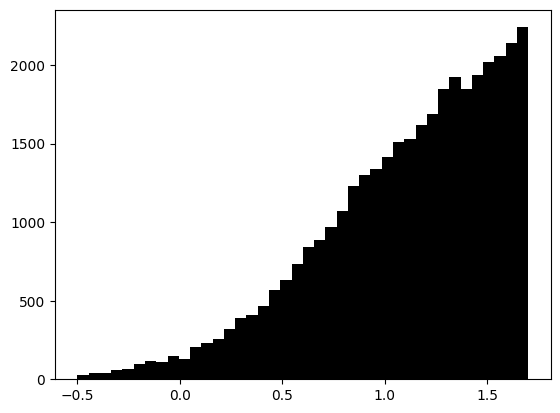

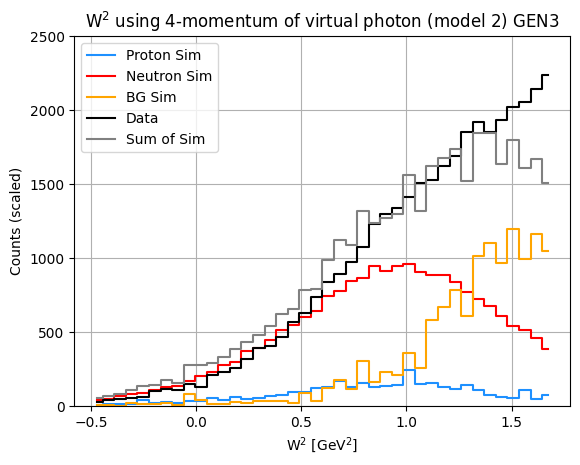

In [534]:

# Data (no scaling/normalization for raw data)
hist_data = plt.hist(generic["W2"][dataW2], bins=40, range=(-.5, 1.7), color='black')
counts_data, bins_data = hist_data[0], hist_data[1]
scale=np.sum(counts_data)

# Sim proton
hist_p = plt.hist(genericSim["W2"][protonW2], bins=40,weights=weight[protonW2], range=(-.5, 1.7), color='dodgerblue', alpha=0.5)
counts_p, bins_p = hist_p[0], hist_p[1]
norm_counts_p = counts_p / np.sum(counts_p)
scaled_counts_p = norm_counts_p *f_p

# Sim neutron
hist_n = plt.hist(genericSim["W2"][neutronW2], bins=40, weights=weight[neutronW2],range=(-.5, 1.7), color='red', alpha=0.5)
counts_n, bins_n = hist_n[0], hist_n[1]
norm_counts_n = counts_n / np.sum(counts_n)
scaled_counts_n = norm_counts_n * (f_n)

# Background
hist_bg = plt.hist(genericSimIN["W2"][bgW2], bins=40,weights=genericSimIN["weight"][bgW2], range=(-.5, 1.7), color='orange', alpha=0.5)
counts_bg, bins_bg = hist_bg[0], hist_bg[1]
norm_counts_bg = counts_bg / np.sum(counts_bg)
scaled_counts_bg = norm_counts_bg * (f_bg)


# Bin centers
bin_centers_p = 0.5 * (bins_p[1:] + bins_p[:-1])
bin_centers_n = 0.5 * (bins_n[1:] + bins_n[:-1])
bin_centers_bg = 0.5 * (bins_bg[1:] + bins_bg[:-1])
bin_centers_data = 0.5 * (bins_data[1:] + bins_data[:-1])

# Plot
plt.figure()
plt.step(bin_centers_p, scaled_counts_p*scale, where='mid', color='dodgerblue', label='Proton Sim')
plt.step(bin_centers_n, scaled_counts_n*scale, where='mid', color='red', label='Neutron Sim')
plt.step(bin_centers_bg, scaled_counts_bg*scale, where='mid', color='orange', label='BG Sim')
plt.step(bin_centers_data, counts_data, where='mid', color='black', label='Data')
plt.step(bin_centers_data, scaled_counts_p*scale+scaled_counts_n*scale+scaled_counts_bg*scale, where='mid', color='grey', label='Sum of Sim')

plt.title(r"W$^2$ using 4-momentum of virtual photon (model 2) GEN3")
plt.xlabel(r"W$^2$ [GeV$^2$]")
plt.ylabel("Counts (scaled)")
plt.legend()
plt.grid(True)
plt.ylim(0, 2500)
plt.show()


# Corrections

### Accidentals

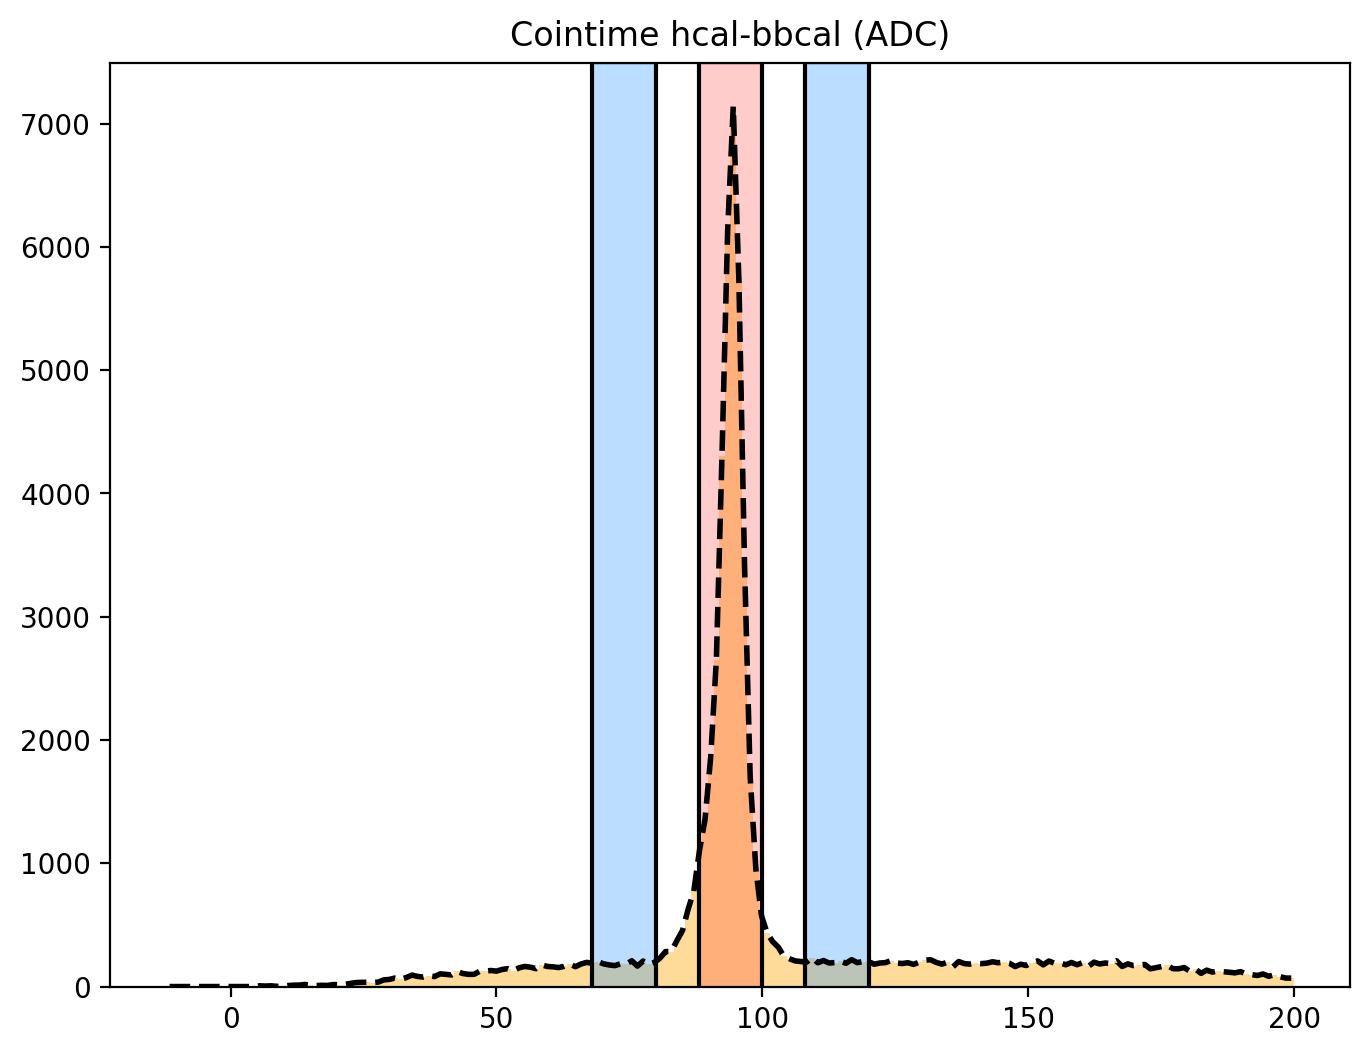

In [535]:

accBinRange=100
plt.figure(figsize=(8,6),dpi=200)
coin_hist,coin_edges=np.histogram(generic["coin_time"][wcut&dycut&dxcut],bins=200,range=(coinmin-accBinRange,coinmax+accBinRange))
coin_centers= (coin_edges[:-1] + coin_edges[1:]) / 2

d=plt.hist(generic["coin_time"][wcut&dycut&dxcut],bins=200,range=(coinmin-accBinRange,coinmax+accBinRange),color='orange',alpha=.4)
plt.plot(coin_centers, coin_hist,'--',color='black',linewidth=2)

plt.title("Cointime hcal-bbcal (ADC)")

plt.axvline(coinmin,color='black')
plt.axvline(coinmax,color='black')
plt.axvspan(coinmin, coinmax, color='red', alpha=0.2)

plt.axvline(coinmin+20,color='black')
plt.axvline(coinmax+20,color='black')
plt.axvspan(coinmin+20, coinmax+20, color='dodgerblue', alpha=0.3)

plt.axvline(coinmin-20,color='black')
plt.axvline(coinmax-20,color='black')
plt.axvspan(coinmin-20, coinmax-20, color='dodgerblue', alpha=0.3)

outside_coin_right=(coin_centers >= coinmin+20) & (coin_centers <= coinmax+20)
outside_coin_left=(coin_centers >= coinmin-20) & (coin_centers <= coinmax-20)
inside_coin=(coin_centers >= coinmin) & (coin_centers <= coinmax)

outside_number=(np.sum(coin_hist[outside_coin_right])+np.sum(coin_hist[outside_coin_left]))/2
inside_number=(np.sum(coin_hist[inside_coin]))

f_acc=outside_number/inside_number
f_acc_error=f_acc * math.sqrt(1 / outside_number + 1 / inside_number)

N_plus: 6780 N_minus: 6790
f_acc: 0.0633+=0.0014 A_acc: -0.000737+-0.0086


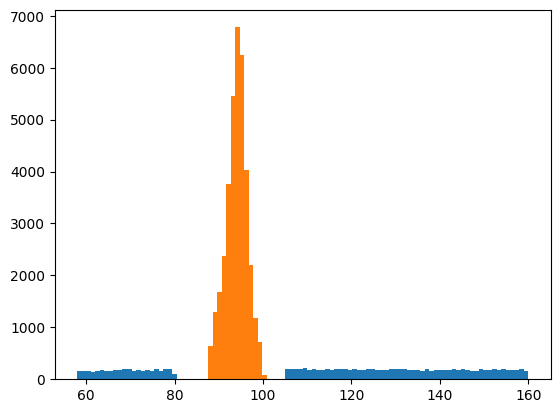

In [536]:
plus_coin_hist,plus_coin_edges=np.histogram(generic["coin_time"][wcut&dycut&dxcut&hpluscut&anticoincut],bins=100,range=(coinmin-30,coinmax+60))
minus_coin_hist,minus_coin_edges=np.histogram(generic["coin_time"][wcut&dycut&dxcut&hminuscut&anticoincut],bins=100,range=(coinmin-30,coinmax+60))
plt.hist(generic["coin_time"][wcut&dycut&dxcut&anticoincut],bins=100,
        range=(coinmin-30,coinmax+60))
plt.hist(generic["coin_time"][wcut&dycut&dxcut&coincut],bins=100,
        range=(coinmin-30,coinmax+60))
coin_plus_total = np.sum(plus_coin_hist)
coin_minus_total = np.sum(minus_coin_hist)

A_acc=(coin_plus_total-coin_minus_total)/(coin_plus_total+coin_minus_total)
A_acc_error=2*math.sqrt(coin_plus_total * coin_minus_total) / (coin_plus_total + coin_minus_total)**(3/2)
print(f"N_plus: {coin_plus_total} N_minus: {coin_minus_total}")
print(f"f_acc: {f_acc:.4f}+={f_acc_error:.4f} A_acc: {A_acc:.6f}+-{A_acc_error:.4f}")


### Inelastic

### Protons

<span style="font-size:1.5em;">
\begin{equation}
A_{\perp} = -\frac{G_{E}^n}{G_{M}^n} \cdot \frac{2\sqrt{\tau(\tau+1)}\tan{\frac{\theta}{2}}}{\left(\frac{G_{E}^n}{G_{M}^n}\right)^2 + \left(\tau + 2\tau(1+\tau)\tan^2\frac{\theta}{2}\right)}
\end{equation}
    </span>

<span style="font-size:3.5em;">
\begin{equation}
A_p=P_{^3He}P_{beam}P_p A_{\perp}(Q^2)
\end{equation}
    </span>

In [537]:
mup=2.793
Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
def load_data(file_path):
    """
    Load the data from the given file path into a pandas DataFrame.
    """
    columns = ["Q2", "GEp/GD", "dGEp/GD", "dGEp_Par/GD", "GMp/mu_p/GD", "dGMp/mu_p/GD", "dGMp_Par/mu_p/GD"]
    data = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=columns)
    return data
def find_closest_row(data, input_Q2):
    """
    Find the row in the data with the Q2 value closest to the input_Q2.
    """
    closest_row = data.iloc[(data['Q2'] - input_Q2).abs().argmin()]
    return closest_row
def main(input_Q2):
    file_path = '../DB/proton_lookup.dat'
    data = load_data(file_path)
    closest_row = find_closest_row(data, input_Q2)
    return closest_row
row=main(Q2)
R=np.round(row[1]/row[4]/mup,4)


#in GeV^2
m=.938
if config=="2":
    tau=Q2/(4*m**2)
    theta=29.5*pi/180
if config=="3":
    tau=Q2/(4*m**2)
    theta=36.5*pi/180
if config=="4":
    tau=Q2/(4*m**2)
    theta=35*pi/180

def Aperp(R, tau, theta):
    tan_half_theta = np.tan(np.radians(theta) / 2)
    numerator = -R * 2 * np.sqrt(tau * (tau + 1)) * tan_half_theta
    denominator = R**2 + (tau + 2 * tau * (1 + tau) * tan_half_theta**2)
    A_perp = numerator / denominator
    return A_perp

Ap=Aperp(R,tau,theta)
P_p=-.04 # seamus thesis
P_beam=CONFIG.Function_JSON("Pbeam",f"../config/cuts{config}.cfg")
P_target=CONFIG.Function_JSON("Ptarget",f"../config/cuts{config}.cfg")

A_p=Ap*P_p*P_beam*P_target/100/100
#Aphys_p=Ap*P_p*P_beam*P_target/100/100

In [538]:
print(f"f_p: {f_p:.4f}+={f_p_error:.4f} A_p: {A_p:.7f}")

f_p: 0.0914+=0.0016 A_p: 0.0000192


### Nitrogen

### Pions 

# Raw Asymmetry

In [539]:
N_minus_raw=len(np.where(helicity[fullcut]==-1)[0])
N_plus_raw=len(np.where(helicity[fullcut]==1)[0])
A_raw=(N_plus_raw-N_minus_raw)/(N_plus_raw+N_minus_raw)
A_raw_error=2*math.sqrt(N_plus_raw * N_minus_raw) / (N_plus_raw + N_minus_raw)**(3/2)
print(f"N_plus: {N_plus_raw} N_minus: {N_minus_raw}")
print(f"A_raw: {A_raw:.4f}+={A_raw_error:.4f}")

N_plus: 18323 N_minus: 17524
A_raw: 0.0223+=0.0053


# Beam and Target Polarimetry

Text(0, 0.5, 'Polarization Percentage(%)')

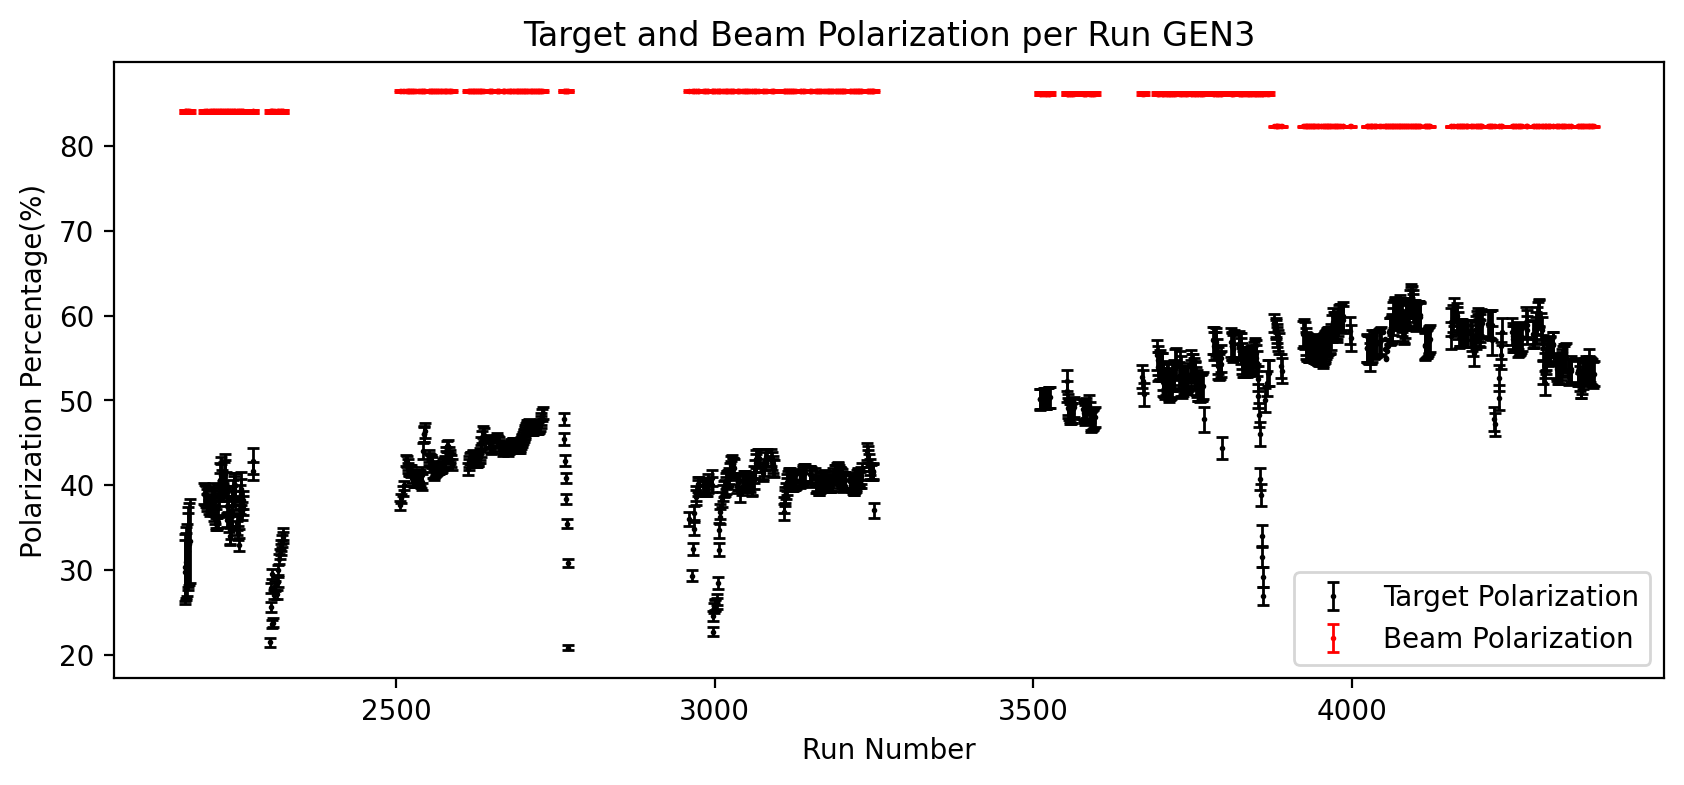

In [540]:
plt.figure(figsize=(10,4),dpi=200)
plt.errorbar(target_run_num,target_pol,target_polE,
             fmt='o',capsize=2,linewidth=1,
             color='black',markersize=1,
             label="Target Polarization")
plt.errorbar(target_run_num,beam_pol,beam_polE,
             fmt='o',capsize=2,linewidth=1,
             color='red',markersize=1,
             label="Beam Polarization")
plt.legend(loc="lower right")
#plt.ylim(40, 50)  # This *calls* the function and sets the y-axis limits
plt.title(f"Target and Beam Polarization per Run GEN{config}")
plt.xlabel("Run Number")
plt.ylabel("Polarization Percentage(%)")

# Run Summation

### Asymmetry per run

In [541]:
%%time
#helicity and runs with QE cuts
runnums = generic["runnum"][fullcut]
pluscut=helicity[fullcut]==1
minuscut=helicity[fullcut]==-1
#Unique runs and compute asymmetry
unique_runnum, run_idx=np.unique(runnums, return_inverse=True)
N_plus_per_run=np.bincount(run_idx, weights=pluscut.astype(int))
N_minus_per_run=np.bincount(run_idx, weights=minuscut.astype(int))
A_raw_per_run=(N_plus_per_run-N_minus_per_run)/(N_plus_per_run+N_minus_per_run)
A_raw_error_per_run=2*(N_plus_per_run * N_minus_per_run)**(1/2) / (N_plus_per_run + N_minus_per_run)**(3/2)

CPU times: user 24.1 ms, sys: 93 µs, total: 24.2 ms
Wall time: 23.4 ms


### Polarizations per run

In [542]:
matching_pol_runs_i = np.searchsorted(target_run_num, unique_runnum)
P_beam_per_run = beam_pol[matching_pol_runs_i]/100
P_beamE_per_run = beam_polE[matching_pol_runs_i]/100
P_target_per_run = target_pol[matching_pol_runs_i]/100
P_targetE_per_run = target_polE[matching_pol_runs_i]/100



# A_Phys Calculation

In [543]:
A_inelastic=.0015 
A_inelastic_error=.0005 

In [544]:
f_nitrogen=.2
f_nitrogen_error=.001

In [545]:
f_inelastic=f_bg-f_acc
f_inelastic_error=np.sqrt(f_acc_error**2+f_bg_error**2+f_nitrogen_error**2)

In [546]:
def weighted_avg(values, errors):
    weights = 1 / errors**2
    return np.sum(values * weights) / np.sum(weights)


In [551]:
fA=f_acc*A_acc + f_inelastic*A_inelastic + f_p*A_p
f=f_acc+f_nitrogen+f_p+f_inelastic


#####ERROR######
fA_error = np.sqrt(
    (f_acc * A_acc_error)**2 + (A_acc * f_acc_error)**2 +
    (f_inelastic * A_inelastic_error)**2 + (A_inelastic * f_inelastic_error)**2 +
    (f_p * 0)**2 + (A_p * f_p_error)**2
)

f_error = np.sqrt(f_acc_error**2 + f_nitrogen_error**2 + f_p_error**2 + f_inelastic_error**2)


P_neutron = 0.95 

#______________________________Statistical_________________________________________________________
A_corrected_per_run = (A_raw_per_run - fA) / (1 - f)
f_n=(1-f)
A_phys_per_run = A_corrected_per_run / (P_beam_per_run * P_target_per_run * P_neutron)
statistical_error_per_run=A_raw_error_per_run/(P_beam_per_run * P_target_per_run * P_neutron*(1-f))
#______________________________Statistical_________________________________________________________





weights = 1 / (statistical_error_per_run**2)
numerator = np.sum(A_phys_per_run * weights)
denominator = np.sum(weights)



A_phys_weighted_avg = numerator / denominator
A_phys_stat_error=1/((denominator)**(1/2))


#______________________________Systematic_______________________
P_total = P_beam_avg * P_target_avg * P_neutron
f_n = 1 - f_nitrogen
Pfn = P_total * f_n

# Central value of A_phys for error propagation
A_phys = A_phys_weighted_avg

# Individual terms from error propagation formula
term_acc_A = (f_acc**2 * A_acc_error**2) / Pfn**2
term_acc_f = ((P_total * A_phys - A_acc)**2 * f_acc_error**2) / Pfn**2
term_inel_A = (f_inelastic**2 * A_inelastic_error**2) / Pfn**2
term_inel_f = ((P_total * A_phys - A_inelastic)**2 * f_inelastic_error**2) / Pfn**2
term_p = ((P_total * A_phys - A_p)**2 * f_p_error**2) / Pfn**2
term_nitrogen = ((A_phys / (1 - f_nitrogen))**2) * f_nitrogen_error**2
term_polarization = A_phys**2 * (
    (P_beamE_per_run.mean() / P_beam_avg)**2 + (P_targetE_per_run.mean()/ P_target_avg)**2
)

# Total systematic error
sigma_sys_squared = (
    term_acc_A + term_acc_f +
    term_inel_A + term_inel_f +
    term_p + term_nitrogen +
    term_polarization
)

A_phys_sys_error = np.sqrt(sigma_sys_squared)

#______________________________Systematic_______________________




A_phys_comb_error=np.sqrt(A_phys_sys_error**2+A_phys_stat_error**2)


print(f"A_phys_weighted_avg: {A_phys_weighted_avg:.5f}+-{A_phys_stat_error:.5f}+-{A_phys_sys_error:.5f}")
print(f"Combined Error: {A_phys_comb_error:.5f}")

A_phys_weighted_avg: 0.17993+-0.04217+-0.00429
Combined Error: 0.04239


In [550]:


# Optional: Print breakdown of contributions
def print_sys_contributions():
    terms = {
        'acc (A)': term_acc_A,
        'acc (f)': term_acc_f,
        'inel (A)': term_inel_A,
        'inel (f)': term_inel_f,
        'proton (f)': term_p,
        'nitrogen (f)': term_nitrogen,
        'polarization': term_polarization
    }

    total = sigma_sys_squared
    print("Absolute Contributions to Systematic Error on A_phys:")
    for name, val in terms.items():
        print(f"  {name:<15}: {np.sqrt(val):.5f}")
    print(f"=> Total Sys Err  : {A_phys_sys_error:.5f}\n")

    print("Relative Contributions to Systematic Error on A_phys:")
    for name, val in terms.items():
        print(f"  {name:<15}: {100 * val / total:.5f}%")
    print(f"=> Total Sys Err  : {A_phys_sys_error:.5f}")

# Final printout
print_sys_contributions()
print(f"\nA_phys_weighted_avg: {A_phys:.5f} +- {A_phys_sys_error:.5f} (systematic)")


Absolute Contributions to Systematic Error on A_phys:
  acc (A)        : 0.00200
  acc (f)        : 0.00031
  inel (A)       : 0.00052
  inel (f)       : 0.00085
  proton (f)     : 0.00037
  nitrogen (f)   : 0.00022
  polarization   : 0.00362
=> Total Sys Err  : 0.00429

Relative Contributions to Systematic Error on A_phys:
  acc (A)        : 21.74785%
  acc (f)        : 0.51381%
  inel (A)       : 1.45713%
  inel (f)       : 3.94691%
  proton (f)     : 0.72462%
  nitrogen (f)   : 0.27511%
  polarization   : 71.33456%
=> Total Sys Err  : 0.00429

A_phys_weighted_avg: 0.17993 +- 0.00429 (systematic)


# GEn Calculation

### Average Kinematics 

In [552]:
goodhel=(helicity[fullcut]==1) | (helicity[fullcut]==-1)

In [553]:
Q2_avg=np.mean(generic["Q2"][fullcut][goodhel])
etheta_avg=np.mean(generic["etheta"][fullcut][goodhel])

In [554]:
tau_avg=Q2_avg/(4*m**2)

In [555]:
epsilon_avg=1/(1+2*(1+tau_avg)*math.tan(etheta_avg/2)**2)

In [556]:
print(f"epsilon = {epsilon_avg}")
print(f"tau_avg = {tau_avg}")
print(f"Q2 = {Q2_avg}")

epsilon = 0.6214947260728597
tau_avg = 1.8819136655086781
Q2 = 6.6231617884632685


### Px and Pz

In [557]:
trPx = generic["trPx"][fullcut][goodhel]
trPy = generic["trPy"][fullcut][goodhel]
trPz = generic["trPz"][fullcut][goodhel]
ebeam = generic["ebeam"][fullcut][goodhel]

Px,Pz=compute_Px_Pz(trPx,trPy,trPz,ebeam,spintheta,spinphi)
Px_avg=np.mean(Px)
Pz_avg=np.mean(Pz)
print(f"Px: {Px_avg:.4f} Pz: {Pz_avg:.4f}")

Px: 0.9917 Pz: -0.0316


#  $G^n_E/G^n_M$

\begin{equation}
\begin{aligned}
A &= \frac{\bar{\epsilon}}{\bar{\tau}} A_{\text{phys}} \\
B &= \sqrt{\frac{2\bar{\epsilon}(1 - \bar{\epsilon})}{\bar{\tau}}} \, \bar{P}_x \\
C &= A_{\text{phys}} + \sqrt{1 - \bar{\epsilon}^2} \, \bar{P}_z
\end{aligned}
\tag{1}
\end{equation}


\begin{equation}
\begin{aligned}
- A_{\text{phys}} - \frac{\bar{\epsilon}}{\bar{\tau}} A_{\text{phys}} \Lambda^2 
&= \Lambda \sqrt{\frac{2\bar{\epsilon}(1 - \bar{\epsilon})}{\bar{\tau}}} \, \bar{P}_x + \sqrt{1 - \bar{\epsilon}^2} \, \bar{P}_z \\
0 &= \left( \frac{\bar{\epsilon}}{\bar{\tau}} A_{\text{phys}} \right) \Lambda^2 
+ \left( \sqrt{\frac{2\bar{\epsilon}(1 - \bar{\epsilon})}{\bar{\tau}}} \, \bar{P}_x \right) \Lambda 
+ \left( A_{\text{phys}} + \sqrt{1 - \bar{\epsilon}^2} \, \bar{P}_z \right) \\
0 &= A \Lambda^2 + B \Lambda + C
\end{aligned}
\tag{2}
\end{equation}


In [558]:
A=epsilon_avg/tau_avg*A_phys_weighted_avg
B=np.sqrt((2*epsilon_avg)*(1-epsilon_avg)/tau_avg)*Px_avg
C=A_phys_weighted_avg+np.sqrt(1-epsilon_avg**2)*Pz_avg

In [559]:
A_error = (epsilon_avg / tau_avg) * A_phys_comb_error
C_error = A_phys_comb_error

# Results
print(f"A = {A:.5f} ± {A_error:.5f}")
print(f"B = {B:.5f} (no propagated error)")
print(f"C = {C:.5f} ± {C_error:.5f}")

A = 0.05942 ± 0.01400
B = 0.49586 (no propagated error)
C = 0.15519 ± 0.04239


In [414]:
ratio=(-B+np.sqrt(B**2-4*A*C))/(2*A)

In [562]:
discriminant = B**2 - 4*A*C
ratio_error = np.sqrt(((C / (A * np.sqrt(discriminant)) + ratio / A)**2) * A_error**2 + (C_error**2 / discriminant))


In [563]:
print(f"GEn/GMn*muN: {ratio*muN:.5f}+-{ratio_error*muN:.5f}")

GEn/GMn*muN: 0.61413+--0.17731


# Tables

# Plots

In [572]:
ratio_error

0.09281537361693606

In [564]:
GEGM=ratio
GEGME=ratio_error

In [573]:
GEN2Data = {
    'Q2': [Q2_avg],
    'ExpName': ['GEn-II'],
    'R': [muN*GEGM ],
    'R_err': [abs(muN*GEGME)],
    'GEn': [0],   # assuming GEn and GEn_err are present in the file
    'GEn_err': [0]
}

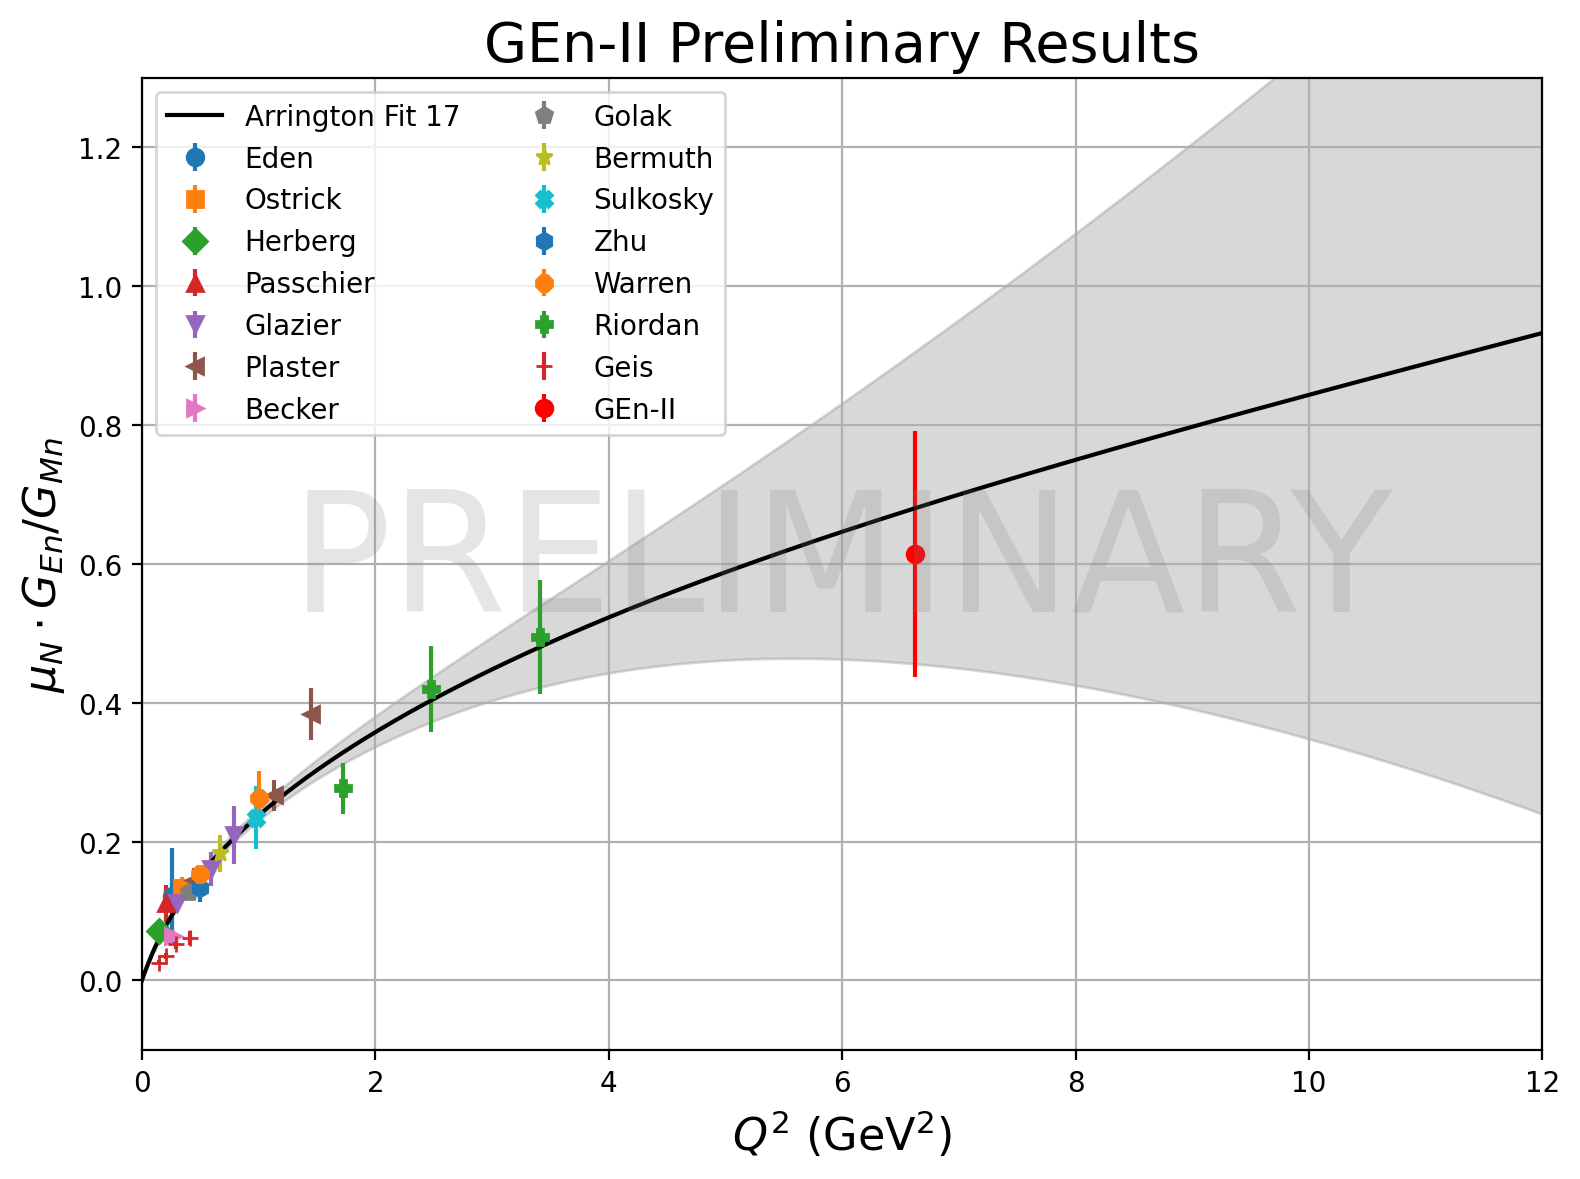

In [574]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GETFF import Function_GETFF  # Assuming you have this imported somewhere

# Load theory Q2 and GEn/GD ratio
GEntheory = np.transpose(np.loadtxt('../DB/neutron_lookup.dat'))
Q2t = np.sort(GEntheory[0])

# Calculate GE/GM and uncertainties using GETFF
GEGD, GEGDE, GMGD, GMGDE = [], [], [], []
for q2 in Q2t:
    GEGD.append(Function_GETFF(3, q2)[0])
    GEGDE.append(Function_GETFF(3, q2)[1])
    GMGD.append(Function_GETFF(4, q2)[0])
    GMGDE.append(Function_GETFF(4, q2)[1])

GEGD = np.array(GEGD)
GEGDE = np.array(GEGDE)
GMGD = np.array(GMGD)
GMGDE = np.array(GMGDE)

# Error propagation: GE/GM with uncertainty
def eprop(GE, GEE, GM, GMM):
    R = GE / GM
    fractional_error = np.sqrt((GEE / GE)**2 + (GMM / GM)**2)
    return R, R * fractional_error

RatFit, RatFitE = eprop(GEGD, GEGDE, GMGD, GMGDE)

# Load world data
df = pd.read_csv("../DB/GEn_World_Data.csv")
mu_n = 1.91

# Setup plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X', 'h', '8', 'P', '+', 'x', '|', '_']
experiments = df["Experiment"].unique()
markers = {exp: marker_styles[i % len(marker_styles)] for i, exp in enumerate(experiments)}

# Plot world data
for exp in experiments:
    subset = df[df["Experiment"] == exp]
    ax.errorbar(subset["Q2"], mu_n * subset["GEn"] / subset["GMn"],
                subset["RatE"], fmt=markers[exp], label=exp)
plt.errorbar(GEN2Data['Q2'],GEN2Data['R'],GEN2Data['R_err'],fmt='o',color='red',label='GEn-II')

# Plot fit and shaded error band
ax.plot(Q2t, RatFit, color='black', label='Arrington Fit 17')
ax.fill_between(Q2t, RatFit - RatFitE, RatFit + RatFitE, color='gray', alpha=0.3)

# Watermark and labels
ax.text(0.5, 0.5, 'PRELIMINARY', fontsize=60, color='gray',
        ha='center', va='center', alpha=0.2, transform=ax.transAxes)

ax.set_xlim(0, 12)
ax.set_ylim(-0.1, 1.3)
ax.grid(True)
ax.set_xlabel('$Q^2$ (GeV$^2$)', fontsize=16)
ax.set_ylabel(r'$\mu_N \cdot G_{En} / G_{Mn}$', fontsize=16)
ax.set_title('GEn-II Preliminary Results', fontsize=20)
ax.legend(loc='upper left', fontsize=10, ncol=2)

plt.tight_layout()
plt.savefig("PrelimResults.pdf")
plt.show()
